# Pipeline

### Data input

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing the dataset
df = pd.read_csv('data/creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

### Data preprocessing

### Model hyperparameter tuning

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer 

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    LogisticRegression()
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'logisticregression__C': [ 0.1, 1, 5],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

As the data set in really unbalanced, we will use the F1 score as the metric to evaluate the model performance.

In [4]:
from sklearn.model_selection import train_test_split
f1_score_list_lg = []
k=5

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2)

# Train model
grid = GridSearchCV(pipeline, param_grid=params_grid, cv=4, scoring="f1", verbose=3)
grid.fit(X_train, y_train)
model = grid.best_estimator_

for _ in range(k):
    # Evaluate model
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict_proba(X_test)[:,-1] > 0.2)
    y_test = pd.DataFrame(y_test)
    f1_score_list_lg.append(f1_score(y_test, y_pred))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.781 total time=  12.6s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.671 total time=   0.4s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.659 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.752 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.756 total time=   0.6s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.679 total time=   0.6s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.663 total time=   0.6s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.781 total time=   1.2s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.679 total time=   1.1s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.674 total time=   1.1s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.791 total time=   1.2s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.781 total time=   0.5s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.671 total time=   0.5s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.659 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.752 total time=   0.5s
[CV 

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

In [5]:
print(f"The average f1 score for {k} LogisticRegression is: {sum(f1_score_list_lg)/k}, with the following parameters:\n {grid.best_params_}")

The average f1 score for 5 LogisticRegression is: 0.7765472344065489, with the following parameters:
 {'logisticregression__C': 1, 'logisticregression__solver': 'lbfgs', 'selectkbest__k': 25}


For LogisticRegression, we manage to have an average f1 score of 0.78 for 5 differents train/test splits. We take 0.2 as the threshold of the model, to better recognize the fraud.

In [6]:
import xgboost as xgb

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    xgb.XGBClassifier(early_stopping_rounds=2, tree_method='hist')
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.05],
}

In [7]:
# Split data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
train, validation = train_test_split(train, test_size=0.2)
Dtrain = xgb.DMatrix(train.drop(['Class'], axis=1), label=train['Class'])
Dval = xgb.DMatrix(validation.drop(['Class'], axis=1), label=validation['Class'])
Dtest = xgb.DMatrix(test.drop(['Class'], axis=1), label=test['Class'])

search_cv = []

for eta in [0.05, 0.1, 0.5]:
    for mdepth in [3, 7]:
        for tree_method in ['hist', 'approx', 'auto']:
            for threshold in [0.2, 0.3, 0.4, 0.5]:
                # Train model
                param = {
                    'max_depth': mdepth,
                    'eta': eta,
                    'objective': 'binary:logistic',
                    'tree_method': tree_method,
                }

                # Evaluate model
                num_round = 100
                eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
                bst = xgb.train(param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)

                # Model evaluation
                y_pred = pd.DataFrame(bst.predict(Dval) > threshold)
                y_val = pd.DataFrame(validation['Class'])
                f1_score(y_val, y_pred)
                search_cv.append([param, f1_score(y_val, y_pred), threshold])

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64451
[10]	eval-logloss:0.33739	train-logloss:0.33757
[20]	eval-logloss:0.19064	train-logloss:0.19093
[30]	eval-logloss:0.11163	train-logloss:0.11201
[40]	eval-logloss:0.06676	train-logloss:0.06721
[50]	eval-logloss:0.04058	train-logloss:0.04109
[60]	eval-logloss:0.02506	train-logloss:0.02563
[70]	eval-logloss:0.01579	train-logloss:0.01641
[80]	eval-logloss:0.01022	train-logloss:0.01088
[90]	eval-logloss:0.00688	train-logloss:0.00756
[99]	eval-logloss:0.00503	train-logloss:0.00572
[0]	eval-logloss:0.64449	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33739	train-logloss:0.33757
[20]	eval-logloss:0.19064	train-logloss:0.19093
[30]	eval-logloss:0.11163	train-logloss:0.11201
[40]	eval-logloss:0.06676	train-logloss:0.06721
[50]	eval-logloss:0.04058	train-logloss:0.04109
[60]	eval-logloss:0.02506	train-logloss:0.02563
[70]	eval-logloss:0.01579	train-logloss:0.01641
[80]	eval-logloss:0.01022	train-logloss:0.01088
[90]	eval-logloss:0.00688	train-logloss:0.00756
[99]	eval-logloss:0.00503	train-logloss:0.00572
[0]	eval-logloss:0.64449	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33739	train-logloss:0.33757
[20]	eval-logloss:0.19064	train-logloss:0.19093
[30]	eval-logloss:0.11163	train-logloss:0.11201
[40]	eval-logloss:0.06676	train-logloss:0.06721
[50]	eval-logloss:0.04058	train-logloss:0.04109
[60]	eval-logloss:0.02506	train-logloss:0.02563
[70]	eval-logloss:0.01579	train-logloss:0.01641
[80]	eval-logloss:0.01022	train-logloss:0.01088
[90]	eval-logloss:0.00688	train-logloss:0.00756
[99]	eval-logloss:0.00503	train-logloss:0.00572
[0]	eval-logloss:0.64449	train-logloss:0.64451
[10]	eval-logloss:0.33739	train-logloss:0.33757


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.19064	train-logloss:0.19093
[30]	eval-logloss:0.11163	train-logloss:0.11201
[40]	eval-logloss:0.06676	train-logloss:0.06721
[50]	eval-logloss:0.04058	train-logloss:0.04109
[60]	eval-logloss:0.02506	train-logloss:0.02563
[70]	eval-logloss:0.01579	train-logloss:0.01641
[80]	eval-logloss:0.01022	train-logloss:0.01088
[90]	eval-logloss:0.00688	train-logloss:0.00756
[99]	eval-logloss:0.00503	train-logloss:0.00572


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64451
[10]	eval-logloss:0.33738	train-logloss:0.33756
[20]	eval-logloss:0.19063	train-logloss:0.19092
[30]	eval-logloss:0.11160	train-logloss:0.11198
[40]	eval-logloss:0.06671	train-logloss:0.06715
[50]	eval-logloss:0.04050	train-logloss:0.04100
[60]	eval-logloss:0.02497	train-logloss:0.02553
[70]	eval-logloss:0.01569	train-logloss:0.01629
[80]	eval-logloss:0.01013	train-logloss:0.01077
[90]	eval-logloss:0.00680	train-logloss:0.00745
[99]	eval-logloss:0.00497	train-logloss:0.00561
[0]	eval-logloss:0.64449	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33756
[20]	eval-logloss:0.19063	train-logloss:0.19092
[30]	eval-logloss:0.11160	train-logloss:0.11198
[40]	eval-logloss:0.06671	train-logloss:0.06715
[50]	eval-logloss:0.04050	train-logloss:0.04100
[60]	eval-logloss:0.02497	train-logloss:0.02553
[70]	eval-logloss:0.01569	train-logloss:0.01629
[80]	eval-logloss:0.01013	train-logloss:0.01077
[90]	eval-logloss:0.00680	train-logloss:0.00745
[99]	eval-logloss:0.00497	train-logloss:0.00561
[0]	eval-logloss:0.64449	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33756
[20]	eval-logloss:0.19063	train-logloss:0.19092
[30]	eval-logloss:0.11160	train-logloss:0.11198
[40]	eval-logloss:0.06671	train-logloss:0.06715
[50]	eval-logloss:0.04050	train-logloss:0.04100
[60]	eval-logloss:0.02497	train-logloss:0.02553
[70]	eval-logloss:0.01569	train-logloss:0.01629
[80]	eval-logloss:0.01013	train-logloss:0.01077
[90]	eval-logloss:0.00680	train-logloss:0.00745
[99]	eval-logloss:0.00497	train-logloss:0.00561
[0]	eval-logloss:0.64449	train-logloss:0.64451


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33738	train-logloss:0.33756
[20]	eval-logloss:0.19063	train-logloss:0.19092
[30]	eval-logloss:0.11160	train-logloss:0.11198
[40]	eval-logloss:0.06671	train-logloss:0.06715
[50]	eval-logloss:0.04050	train-logloss:0.04100
[60]	eval-logloss:0.02497	train-logloss:0.02553
[70]	eval-logloss:0.01569	train-logloss:0.01629
[80]	eval-logloss:0.01013	train-logloss:0.01077
[90]	eval-logloss:0.00680	train-logloss:0.00745
[99]	eval-logloss:0.00497	train-logloss:0.00561


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64451	train-logloss:0.64453
[10]	eval-logloss:0.33750	train-logloss:0.33762
[20]	eval-logloss:0.19072	train-logloss:0.19093
[30]	eval-logloss:0.11168	train-logloss:0.11197
[40]	eval-logloss:0.06676	train-logloss:0.06713
[50]	eval-logloss:0.04052	train-logloss:0.04098
[60]	eval-logloss:0.02499	train-logloss:0.02551
[70]	eval-logloss:0.01569	train-logloss:0.01628
[80]	eval-logloss:0.01014	train-logloss:0.01076
[90]	eval-logloss:0.00681	train-logloss:0.00744
[99]	eval-logloss:0.00498	train-logloss:0.00559


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64451	train-logloss:0.64453
[10]	eval-logloss:0.33750	train-logloss:0.33762
[20]	eval-logloss:0.19072	train-logloss:0.19093
[30]	eval-logloss:0.11168	train-logloss:0.11197
[40]	eval-logloss:0.06676	train-logloss:0.06713
[50]	eval-logloss:0.04052	train-logloss:0.04098
[60]	eval-logloss:0.02499	train-logloss:0.02551
[70]	eval-logloss:0.01569	train-logloss:0.01628
[80]	eval-logloss:0.01014	train-logloss:0.01076
[90]	eval-logloss:0.00681	train-logloss:0.00744
[99]	eval-logloss:0.00498	train-logloss:0.00559


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64451	train-logloss:0.64453
[10]	eval-logloss:0.33750	train-logloss:0.33762
[20]	eval-logloss:0.19072	train-logloss:0.19093
[30]	eval-logloss:0.11168	train-logloss:0.11197
[40]	eval-logloss:0.06676	train-logloss:0.06713
[50]	eval-logloss:0.04052	train-logloss:0.04098
[60]	eval-logloss:0.02499	train-logloss:0.02551
[70]	eval-logloss:0.01569	train-logloss:0.01628
[80]	eval-logloss:0.01014	train-logloss:0.01076
[90]	eval-logloss:0.00681	train-logloss:0.00744
[99]	eval-logloss:0.00498	train-logloss:0.00559


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64451	train-logloss:0.64453
[10]	eval-logloss:0.33750	train-logloss:0.33762
[20]	eval-logloss:0.19072	train-logloss:0.19093
[30]	eval-logloss:0.11168	train-logloss:0.11197
[40]	eval-logloss:0.06676	train-logloss:0.06713
[50]	eval-logloss:0.04052	train-logloss:0.04098
[60]	eval-logloss:0.02499	train-logloss:0.02551
[70]	eval-logloss:0.01569	train-logloss:0.01628
[80]	eval-logloss:0.01014	train-logloss:0.01076
[90]	eval-logloss:0.00681	train-logloss:0.00744
[99]	eval-logloss:0.00498	train-logloss:0.00559


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64450	train-logloss:0.64448
[10]	eval-logloss:0.33734	train-logloss:0.33732
[20]	eval-logloss:0.19054	train-logloss:0.19056
[30]	eval-logloss:0.11152	train-logloss:0.11156
[40]	eval-logloss:0.06664	train-logloss:0.06672
[50]	eval-logloss:0.04045	train-logloss:0.04055
[60]	eval-logloss:0.02492	train-logloss:0.02500
[70]	eval-logloss:0.01564	train-logloss:0.01568
[80]	eval-logloss:0.01008	train-logloss:0.01006
[90]	eval-logloss:0.00674	train-logloss:0.00663
[99]	eval-logloss:0.00489	train-logloss:0.00469
[0]	eval-logloss:0.64450	train-logloss:0.64448


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33734	train-logloss:0.33732
[20]	eval-logloss:0.19054	train-logloss:0.19056
[30]	eval-logloss:0.11152	train-logloss:0.11156
[40]	eval-logloss:0.06664	train-logloss:0.06672
[50]	eval-logloss:0.04045	train-logloss:0.04055
[60]	eval-logloss:0.02492	train-logloss:0.02500
[70]	eval-logloss:0.01564	train-logloss:0.01568
[80]	eval-logloss:0.01008	train-logloss:0.01006
[90]	eval-logloss:0.00674	train-logloss:0.00663
[99]	eval-logloss:0.00489	train-logloss:0.00469
[0]	eval-logloss:0.64450	train-logloss:0.64448


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33734	train-logloss:0.33732
[20]	eval-logloss:0.19054	train-logloss:0.19056
[30]	eval-logloss:0.11152	train-logloss:0.11156
[40]	eval-logloss:0.06664	train-logloss:0.06672
[50]	eval-logloss:0.04045	train-logloss:0.04055
[60]	eval-logloss:0.02492	train-logloss:0.02500
[70]	eval-logloss:0.01564	train-logloss:0.01568
[80]	eval-logloss:0.01008	train-logloss:0.01006
[90]	eval-logloss:0.00674	train-logloss:0.00663
[99]	eval-logloss:0.00489	train-logloss:0.00469
[0]	eval-logloss:0.64450	train-logloss:0.64448


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.33734	train-logloss:0.33732
[20]	eval-logloss:0.19054	train-logloss:0.19056
[30]	eval-logloss:0.11152	train-logloss:0.11156
[40]	eval-logloss:0.06664	train-logloss:0.06672
[50]	eval-logloss:0.04045	train-logloss:0.04055
[60]	eval-logloss:0.02492	train-logloss:0.02500
[70]	eval-logloss:0.01564	train-logloss:0.01568
[80]	eval-logloss:0.01008	train-logloss:0.01006
[90]	eval-logloss:0.00674	train-logloss:0.00663
[99]	eval-logloss:0.00489	train-logloss:0.00469


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64450	train-logloss:0.64448
[10]	eval-logloss:0.33732	train-logloss:0.33731
[20]	eval-logloss:0.19052	train-logloss:0.19056
[30]	eval-logloss:0.11146	train-logloss:0.11157
[40]	eval-logloss:0.06655	train-logloss:0.06672
[50]	eval-logloss:0.04034	train-logloss:0.04053
[60]	eval-logloss:0.02482	train-logloss:0.02498
[70]	eval-logloss:0.01553	train-logloss:0.01568
[80]	eval-logloss:0.00997	train-logloss:0.01007
[90]	eval-logloss:0.00664	train-logloss:0.00666
[99]	eval-logloss:0.00479	train-logloss:0.00472


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64450	train-logloss:0.64448
[10]	eval-logloss:0.33732	train-logloss:0.33731
[20]	eval-logloss:0.19052	train-logloss:0.19056
[30]	eval-logloss:0.11146	train-logloss:0.11157
[40]	eval-logloss:0.06655	train-logloss:0.06672
[50]	eval-logloss:0.04034	train-logloss:0.04053
[60]	eval-logloss:0.02482	train-logloss:0.02498
[70]	eval-logloss:0.01553	train-logloss:0.01568
[80]	eval-logloss:0.00997	train-logloss:0.01007
[90]	eval-logloss:0.00664	train-logloss:0.00666
[99]	eval-logloss:0.00479	train-logloss:0.00472


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64450	train-logloss:0.64448
[10]	eval-logloss:0.33732	train-logloss:0.33731
[20]	eval-logloss:0.19052	train-logloss:0.19056
[30]	eval-logloss:0.11146	train-logloss:0.11157
[40]	eval-logloss:0.06655	train-logloss:0.06672
[50]	eval-logloss:0.04034	train-logloss:0.04053
[60]	eval-logloss:0.02482	train-logloss:0.02498
[70]	eval-logloss:0.01553	train-logloss:0.01568
[80]	eval-logloss:0.00997	train-logloss:0.01007
[90]	eval-logloss:0.00664	train-logloss:0.00666
[99]	eval-logloss:0.00479	train-logloss:0.00472


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64450	train-logloss:0.64448
[10]	eval-logloss:0.33732	train-logloss:0.33731
[20]	eval-logloss:0.19052	train-logloss:0.19056
[30]	eval-logloss:0.11146	train-logloss:0.11157
[40]	eval-logloss:0.06655	train-logloss:0.06672
[50]	eval-logloss:0.04034	train-logloss:0.04053
[60]	eval-logloss:0.02482	train-logloss:0.02498
[70]	eval-logloss:0.01553	train-logloss:0.01568
[80]	eval-logloss:0.00997	train-logloss:0.01007
[90]	eval-logloss:0.00664	train-logloss:0.00666
[99]	eval-logloss:0.00479	train-logloss:0.00472


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64448
[10]	eval-logloss:0.33735	train-logloss:0.33733
[20]	eval-logloss:0.19058	train-logloss:0.19057
[30]	eval-logloss:0.11155	train-logloss:0.11157
[40]	eval-logloss:0.06664	train-logloss:0.06673
[50]	eval-logloss:0.04044	train-logloss:0.04057
[60]	eval-logloss:0.02490	train-logloss:0.02503
[70]	eval-logloss:0.01561	train-logloss:0.01571
[80]	eval-logloss:0.01002	train-logloss:0.01010
[90]	eval-logloss:0.00667	train-logloss:0.00668
[99]	eval-logloss:0.00482	train-logloss:0.00474


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64448
[10]	eval-logloss:0.33735	train-logloss:0.33733
[20]	eval-logloss:0.19058	train-logloss:0.19057
[30]	eval-logloss:0.11155	train-logloss:0.11157
[40]	eval-logloss:0.06664	train-logloss:0.06673
[50]	eval-logloss:0.04044	train-logloss:0.04057
[60]	eval-logloss:0.02490	train-logloss:0.02503
[70]	eval-logloss:0.01561	train-logloss:0.01571
[80]	eval-logloss:0.01002	train-logloss:0.01010
[90]	eval-logloss:0.00667	train-logloss:0.00668
[99]	eval-logloss:0.00482	train-logloss:0.00474


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64448
[10]	eval-logloss:0.33735	train-logloss:0.33733
[20]	eval-logloss:0.19058	train-logloss:0.19057
[30]	eval-logloss:0.11155	train-logloss:0.11157
[40]	eval-logloss:0.06664	train-logloss:0.06673
[50]	eval-logloss:0.04044	train-logloss:0.04057
[60]	eval-logloss:0.02490	train-logloss:0.02503
[70]	eval-logloss:0.01561	train-logloss:0.01571
[80]	eval-logloss:0.01002	train-logloss:0.01010
[90]	eval-logloss:0.00667	train-logloss:0.00668
[99]	eval-logloss:0.00482	train-logloss:0.00474


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.64449	train-logloss:0.64448
[10]	eval-logloss:0.33735	train-logloss:0.33733
[20]	eval-logloss:0.19058	train-logloss:0.19057
[30]	eval-logloss:0.11155	train-logloss:0.11157
[40]	eval-logloss:0.06664	train-logloss:0.06673
[50]	eval-logloss:0.04044	train-logloss:0.04057
[60]	eval-logloss:0.02490	train-logloss:0.02503
[70]	eval-logloss:0.01561	train-logloss:0.01571
[80]	eval-logloss:0.01002	train-logloss:0.01010
[90]	eval-logloss:0.00667	train-logloss:0.00668
[99]	eval-logloss:0.00482	train-logloss:0.00474


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59837
[10]	eval-logloss:0.17781	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06287
[30]	eval-logloss:0.02350	train-logloss:0.02408
[40]	eval-logloss:0.00965	train-logloss:0.01031
[50]	eval-logloss:0.00466	train-logloss:0.00535
[60]	eval-logloss:0.00286	train-logloss:0.00353
[70]	eval-logloss:0.00221	train-logloss:0.00282
[80]	eval-logloss:0.00196	train-logloss:0.00248
[90]	eval-logloss:0.00187	train-logloss:0.00227
[99]	eval-logloss:0.00184	train-logloss:0.00212
[0]	eval-logloss:0.59833	train-logloss:0.59837


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17781	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06287
[30]	eval-logloss:0.02350	train-logloss:0.02408
[40]	eval-logloss:0.00965	train-logloss:0.01031
[50]	eval-logloss:0.00466	train-logloss:0.00535
[60]	eval-logloss:0.00286	train-logloss:0.00353
[70]	eval-logloss:0.00221	train-logloss:0.00282
[80]	eval-logloss:0.00196	train-logloss:0.00248
[90]	eval-logloss:0.00187	train-logloss:0.00227
[99]	eval-logloss:0.00184	train-logloss:0.00212
[0]	eval-logloss:0.59833	train-logloss:0.59837


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17781	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06287
[30]	eval-logloss:0.02350	train-logloss:0.02408
[40]	eval-logloss:0.00965	train-logloss:0.01031
[50]	eval-logloss:0.00466	train-logloss:0.00535
[60]	eval-logloss:0.00286	train-logloss:0.00353
[70]	eval-logloss:0.00221	train-logloss:0.00282
[80]	eval-logloss:0.00196	train-logloss:0.00248
[90]	eval-logloss:0.00187	train-logloss:0.00227
[99]	eval-logloss:0.00184	train-logloss:0.00212
[0]	eval-logloss:0.59833	train-logloss:0.59837


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17781	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06287
[30]	eval-logloss:0.02350	train-logloss:0.02408
[40]	eval-logloss:0.00965	train-logloss:0.01031
[50]	eval-logloss:0.00466	train-logloss:0.00535
[60]	eval-logloss:0.00286	train-logloss:0.00353
[70]	eval-logloss:0.00221	train-logloss:0.00282
[80]	eval-logloss:0.00196	train-logloss:0.00248
[90]	eval-logloss:0.00187	train-logloss:0.00227
[99]	eval-logloss:0.00184	train-logloss:0.00212


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59837
[10]	eval-logloss:0.17778	train-logloss:0.17810
[20]	eval-logloss:0.06234	train-logloss:0.06280
[30]	eval-logloss:0.02339	train-logloss:0.02396
[40]	eval-logloss:0.00955	train-logloss:0.01020
[50]	eval-logloss:0.00460	train-logloss:0.00523
[60]	eval-logloss:0.00284	train-logloss:0.00342
[70]	eval-logloss:0.00220	train-logloss:0.00271
[80]	eval-logloss:0.00195	train-logloss:0.00237
[90]	eval-logloss:0.00186	train-logloss:0.00217
[99]	eval-logloss:0.00182	train-logloss:0.00202


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59837
[10]	eval-logloss:0.17778	train-logloss:0.17810
[20]	eval-logloss:0.06234	train-logloss:0.06280
[30]	eval-logloss:0.02339	train-logloss:0.02396
[40]	eval-logloss:0.00955	train-logloss:0.01020
[50]	eval-logloss:0.00460	train-logloss:0.00523
[60]	eval-logloss:0.00284	train-logloss:0.00342
[70]	eval-logloss:0.00220	train-logloss:0.00271
[80]	eval-logloss:0.00195	train-logloss:0.00237
[90]	eval-logloss:0.00186	train-logloss:0.00217
[99]	eval-logloss:0.00182	train-logloss:0.00202


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59837
[10]	eval-logloss:0.17778	train-logloss:0.17810
[20]	eval-logloss:0.06234	train-logloss:0.06280
[30]	eval-logloss:0.02339	train-logloss:0.02396
[40]	eval-logloss:0.00955	train-logloss:0.01020
[50]	eval-logloss:0.00460	train-logloss:0.00523
[60]	eval-logloss:0.00284	train-logloss:0.00342
[70]	eval-logloss:0.00220	train-logloss:0.00271
[80]	eval-logloss:0.00195	train-logloss:0.00237
[90]	eval-logloss:0.00186	train-logloss:0.00217
[99]	eval-logloss:0.00182	train-logloss:0.00202


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59837
[10]	eval-logloss:0.17778	train-logloss:0.17810
[20]	eval-logloss:0.06234	train-logloss:0.06280
[30]	eval-logloss:0.02339	train-logloss:0.02396
[40]	eval-logloss:0.00955	train-logloss:0.01020
[50]	eval-logloss:0.00460	train-logloss:0.00523
[60]	eval-logloss:0.00284	train-logloss:0.00342
[70]	eval-logloss:0.00220	train-logloss:0.00271
[80]	eval-logloss:0.00195	train-logloss:0.00237
[90]	eval-logloss:0.00186	train-logloss:0.00217
[99]	eval-logloss:0.00182	train-logloss:0.00202


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59837	train-logloss:0.59839
[10]	eval-logloss:0.17789	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06278
[30]	eval-logloss:0.02344	train-logloss:0.02395
[40]	eval-logloss:0.00959	train-logloss:0.01019
[50]	eval-logloss:0.00463	train-logloss:0.00522
[60]	eval-logloss:0.00287	train-logloss:0.00339
[70]	eval-logloss:0.00223	train-logloss:0.00268
[80]	eval-logloss:0.00199	train-logloss:0.00233
[90]	eval-logloss:0.00189	train-logloss:0.00212
[99]	eval-logloss:0.00183	train-logloss:0.00196


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59837	train-logloss:0.59839
[10]	eval-logloss:0.17789	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06278
[30]	eval-logloss:0.02344	train-logloss:0.02395
[40]	eval-logloss:0.00959	train-logloss:0.01019
[50]	eval-logloss:0.00463	train-logloss:0.00522
[60]	eval-logloss:0.00287	train-logloss:0.00339
[70]	eval-logloss:0.00223	train-logloss:0.00268
[80]	eval-logloss:0.00199	train-logloss:0.00233
[90]	eval-logloss:0.00189	train-logloss:0.00212
[99]	eval-logloss:0.00183	train-logloss:0.00196
[0]	eval-logloss:0.59837	train-logloss:0.59839


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17789	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06278
[30]	eval-logloss:0.02344	train-logloss:0.02395
[40]	eval-logloss:0.00959	train-logloss:0.01019
[50]	eval-logloss:0.00463	train-logloss:0.00522
[60]	eval-logloss:0.00287	train-logloss:0.00339
[70]	eval-logloss:0.00223	train-logloss:0.00268
[80]	eval-logloss:0.00199	train-logloss:0.00233
[90]	eval-logloss:0.00189	train-logloss:0.00212
[99]	eval-logloss:0.00183	train-logloss:0.00196


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59837	train-logloss:0.59839
[10]	eval-logloss:0.17789	train-logloss:0.17811
[20]	eval-logloss:0.06241	train-logloss:0.06278
[30]	eval-logloss:0.02344	train-logloss:0.02395
[40]	eval-logloss:0.00959	train-logloss:0.01019
[50]	eval-logloss:0.00463	train-logloss:0.00522
[60]	eval-logloss:0.00287	train-logloss:0.00339
[70]	eval-logloss:0.00223	train-logloss:0.00268
[80]	eval-logloss:0.00199	train-logloss:0.00233
[90]	eval-logloss:0.00189	train-logloss:0.00212
[99]	eval-logloss:0.00183	train-logloss:0.00196


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59834	train-logloss:0.59831
[10]	eval-logloss:0.17772	train-logloss:0.17772
[20]	eval-logloss:0.06231	train-logloss:0.06238
[30]	eval-logloss:0.02338	train-logloss:0.02345
[40]	eval-logloss:0.00953	train-logloss:0.00949
[50]	eval-logloss:0.00454	train-logloss:0.00432
[60]	eval-logloss:0.00272	train-logloss:0.00229
[70]	eval-logloss:0.00209	train-logloss:0.00137
[80]	eval-logloss:0.00187	train-logloss:0.00090
[90]	eval-logloss:0.00176	train-logloss:0.00062
[99]	eval-logloss:0.00174	train-logloss:0.00046
[0]	eval-logloss:0.59834	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17772	train-logloss:0.17772
[20]	eval-logloss:0.06231	train-logloss:0.06238
[30]	eval-logloss:0.02338	train-logloss:0.02345
[40]	eval-logloss:0.00953	train-logloss:0.00949
[50]	eval-logloss:0.00454	train-logloss:0.00432
[60]	eval-logloss:0.00272	train-logloss:0.00229
[70]	eval-logloss:0.00209	train-logloss:0.00137
[80]	eval-logloss:0.00187	train-logloss:0.00090
[90]	eval-logloss:0.00176	train-logloss:0.00062
[99]	eval-logloss:0.00174	train-logloss:0.00046
[0]	eval-logloss:0.59834	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17772	train-logloss:0.17772
[20]	eval-logloss:0.06231	train-logloss:0.06238
[30]	eval-logloss:0.02338	train-logloss:0.02345
[40]	eval-logloss:0.00953	train-logloss:0.00949
[50]	eval-logloss:0.00454	train-logloss:0.00432
[60]	eval-logloss:0.00272	train-logloss:0.00229
[70]	eval-logloss:0.00209	train-logloss:0.00137
[80]	eval-logloss:0.00187	train-logloss:0.00090
[90]	eval-logloss:0.00176	train-logloss:0.00062
[99]	eval-logloss:0.00174	train-logloss:0.00046
[0]	eval-logloss:0.59834	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17772	train-logloss:0.17772
[20]	eval-logloss:0.06231	train-logloss:0.06238
[30]	eval-logloss:0.02338	train-logloss:0.02345
[40]	eval-logloss:0.00953	train-logloss:0.00949
[50]	eval-logloss:0.00454	train-logloss:0.00432
[60]	eval-logloss:0.00272	train-logloss:0.00229
[70]	eval-logloss:0.00209	train-logloss:0.00137
[80]	eval-logloss:0.00187	train-logloss:0.00090
[90]	eval-logloss:0.00176	train-logloss:0.00062
[99]	eval-logloss:0.00174	train-logloss:0.00046
[0]	eval-logloss:0.59834	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17770	train-logloss:0.17773
[20]	eval-logloss:0.06223	train-logloss:0.06238
[30]	eval-logloss:0.02329	train-logloss:0.02342
[40]	eval-logloss:0.00939	train-logloss:0.00951
[50]	eval-logloss:0.00440	train-logloss:0.00434
[60]	eval-logloss:0.00262	train-logloss:0.00229
[70]	eval-logloss:0.00198	train-logloss:0.00139
[80]	eval-logloss:0.00177	train-logloss:0.00092
[90]	eval-logloss:0.00167	train-logloss:0.00063
[99]	eval-logloss:0.00166	train-logloss:0.00046


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59834	train-logloss:0.59831
[10]	eval-logloss:0.17770	train-logloss:0.17773
[20]	eval-logloss:0.06223	train-logloss:0.06238
[30]	eval-logloss:0.02329	train-logloss:0.02342
[40]	eval-logloss:0.00939	train-logloss:0.00951
[50]	eval-logloss:0.00440	train-logloss:0.00434
[60]	eval-logloss:0.00262	train-logloss:0.00229
[70]	eval-logloss:0.00198	train-logloss:0.00139
[80]	eval-logloss:0.00177	train-logloss:0.00092
[90]	eval-logloss:0.00167	train-logloss:0.00063
[99]	eval-logloss:0.00166	train-logloss:0.00046


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59834	train-logloss:0.59831
[10]	eval-logloss:0.17770	train-logloss:0.17773
[20]	eval-logloss:0.06223	train-logloss:0.06238
[30]	eval-logloss:0.02329	train-logloss:0.02342
[40]	eval-logloss:0.00939	train-logloss:0.00951
[50]	eval-logloss:0.00440	train-logloss:0.00434
[60]	eval-logloss:0.00262	train-logloss:0.00229
[70]	eval-logloss:0.00198	train-logloss:0.00139
[80]	eval-logloss:0.00177	train-logloss:0.00092
[90]	eval-logloss:0.00167	train-logloss:0.00063
[99]	eval-logloss:0.00166	train-logloss:0.00046
[0]	eval-logloss:0.59834	train-logloss:0.59831


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.17770	train-logloss:0.17773
[20]	eval-logloss:0.06223	train-logloss:0.06238
[30]	eval-logloss:0.02329	train-logloss:0.02342
[40]	eval-logloss:0.00939	train-logloss:0.00951
[50]	eval-logloss:0.00440	train-logloss:0.00434
[60]	eval-logloss:0.00262	train-logloss:0.00229
[70]	eval-logloss:0.00198	train-logloss:0.00139
[80]	eval-logloss:0.00177	train-logloss:0.00092
[90]	eval-logloss:0.00167	train-logloss:0.00063
[99]	eval-logloss:0.00166	train-logloss:0.00046


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59831
[10]	eval-logloss:0.17774	train-logloss:0.17774
[20]	eval-logloss:0.06230	train-logloss:0.06239
[30]	eval-logloss:0.02334	train-logloss:0.02348
[40]	eval-logloss:0.00945	train-logloss:0.00953
[50]	eval-logloss:0.00445	train-logloss:0.00436
[60]	eval-logloss:0.00265	train-logloss:0.00229
[70]	eval-logloss:0.00200	train-logloss:0.00138
[80]	eval-logloss:0.00176	train-logloss:0.00091
[90]	eval-logloss:0.00164	train-logloss:0.00061
[99]	eval-logloss:0.00161	train-logloss:0.00045


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59831
[10]	eval-logloss:0.17774	train-logloss:0.17774
[20]	eval-logloss:0.06230	train-logloss:0.06239
[30]	eval-logloss:0.02334	train-logloss:0.02348
[40]	eval-logloss:0.00945	train-logloss:0.00953
[50]	eval-logloss:0.00445	train-logloss:0.00436
[60]	eval-logloss:0.00265	train-logloss:0.00229
[70]	eval-logloss:0.00200	train-logloss:0.00138
[80]	eval-logloss:0.00176	train-logloss:0.00091
[90]	eval-logloss:0.00164	train-logloss:0.00061
[99]	eval-logloss:0.00161	train-logloss:0.00045


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59831
[10]	eval-logloss:0.17774	train-logloss:0.17774
[20]	eval-logloss:0.06230	train-logloss:0.06239
[30]	eval-logloss:0.02334	train-logloss:0.02348
[40]	eval-logloss:0.00945	train-logloss:0.00953
[50]	eval-logloss:0.00445	train-logloss:0.00436
[60]	eval-logloss:0.00265	train-logloss:0.00229
[70]	eval-logloss:0.00200	train-logloss:0.00138
[80]	eval-logloss:0.00176	train-logloss:0.00091
[90]	eval-logloss:0.00164	train-logloss:0.00061
[99]	eval-logloss:0.00161	train-logloss:0.00045


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59833	train-logloss:0.59831
[10]	eval-logloss:0.17774	train-logloss:0.17774
[20]	eval-logloss:0.06230	train-logloss:0.06239
[30]	eval-logloss:0.02334	train-logloss:0.02348
[40]	eval-logloss:0.00945	train-logloss:0.00953
[50]	eval-logloss:0.00445	train-logloss:0.00436
[60]	eval-logloss:0.00265	train-logloss:0.00229
[70]	eval-logloss:0.00200	train-logloss:0.00138
[80]	eval-logloss:0.00176	train-logloss:0.00091
[90]	eval-logloss:0.00164	train-logloss:0.00061
[99]	eval-logloss:0.00161	train-logloss:0.00045


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31400	train-logloss:0.31418
[10]	eval-logloss:0.00342	train-logloss:0.00407
[20]	eval-logloss:0.00182	train-logloss:0.00202
[30]	eval-logloss:0.00179	train-logloss:0.00140
[40]	eval-logloss:0.00180	train-logloss:0.00100
[50]	eval-logloss:0.00176	train-logloss:0.00072
[60]	eval-logloss:0.00181	train-logloss:0.00050
[70]	eval-logloss:0.00183	train-logloss:0.00036
[80]	eval-logloss:0.00185	train-logloss:0.00027
[90]	eval-logloss:0.00179	train-logloss:0.00019
[99]	eval-logloss:0.00181	train-logloss:0.00015
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00342	train-logloss:0.00407
[20]	eval-logloss:0.00182	train-logloss:0.00202
[30]	eval-logloss:0.00179	train-logloss:0.00140
[40]	eval-logloss:0.00180	train-logloss:0.00100
[50]	eval-logloss:0.00176	train-logloss:0.00072
[60]	eval-logloss:0.00181	train-logloss:0.00050
[70]	eval-logloss:0.00183	train-logloss:0.00036
[80]	eval-logloss:0.00185	train-logloss:0.00027
[90]	eval-logloss:0.00179	train-logloss:0.00019
[99]	eval-logloss:0.00181	train-logloss:0.00015
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00342	train-logloss:0.00407
[20]	eval-logloss:0.00182	train-logloss:0.00202
[30]	eval-logloss:0.00179	train-logloss:0.00140
[40]	eval-logloss:0.00180	train-logloss:0.00100
[50]	eval-logloss:0.00176	train-logloss:0.00072
[60]	eval-logloss:0.00181	train-logloss:0.00050
[70]	eval-logloss:0.00183	train-logloss:0.00036
[80]	eval-logloss:0.00185	train-logloss:0.00027
[90]	eval-logloss:0.00179	train-logloss:0.00019
[99]	eval-logloss:0.00181	train-logloss:0.00015
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00342	train-logloss:0.00407
[20]	eval-logloss:0.00182	train-logloss:0.00202
[30]	eval-logloss:0.00179	train-logloss:0.00140
[40]	eval-logloss:0.00180	train-logloss:0.00100
[50]	eval-logloss:0.00176	train-logloss:0.00072
[60]	eval-logloss:0.00181	train-logloss:0.00050
[70]	eval-logloss:0.00183	train-logloss:0.00036
[80]	eval-logloss:0.00185	train-logloss:0.00027
[90]	eval-logloss:0.00179	train-logloss:0.00019
[99]	eval-logloss:0.00181	train-logloss:0.00015
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00338	train-logloss:0.00395
[20]	eval-logloss:0.00192	train-logloss:0.00192
[30]	eval-logloss:0.00188	train-logloss:0.00134
[40]	eval-logloss:0.00188	train-logloss:0.00097
[50]	eval-logloss:0.00177	train-logloss:0.00067
[60]	eval-logloss:0.00167	train-logloss:0.00047
[70]	eval-logloss:0.00170	train-logloss:0.00032
[80]	eval-logloss:0.00173	train-logloss:0.00023
[90]	eval-logloss:0.00176	train-logloss:0.00017
[99]	eval-logloss:0.00172	train-logloss:0.00013
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00338	train-logloss:0.00395
[20]	eval-logloss:0.00192	train-logloss:0.00192
[30]	eval-logloss:0.00188	train-logloss:0.00134
[40]	eval-logloss:0.00188	train-logloss:0.00097
[50]	eval-logloss:0.00177	train-logloss:0.00067
[60]	eval-logloss:0.00167	train-logloss:0.00047
[70]	eval-logloss:0.00170	train-logloss:0.00032
[80]	eval-logloss:0.00173	train-logloss:0.00023
[90]	eval-logloss:0.00176	train-logloss:0.00017
[99]	eval-logloss:0.00172	train-logloss:0.00013


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31400	train-logloss:0.31418
[10]	eval-logloss:0.00338	train-logloss:0.00395
[20]	eval-logloss:0.00192	train-logloss:0.00192
[30]	eval-logloss:0.00188	train-logloss:0.00134
[40]	eval-logloss:0.00188	train-logloss:0.00097
[50]	eval-logloss:0.00177	train-logloss:0.00067
[60]	eval-logloss:0.00167	train-logloss:0.00047
[70]	eval-logloss:0.00170	train-logloss:0.00032
[80]	eval-logloss:0.00173	train-logloss:0.00023
[90]	eval-logloss:0.00176	train-logloss:0.00017
[99]	eval-logloss:0.00172	train-logloss:0.00013
[0]	eval-logloss:0.31400	train-logloss:0.31418


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00338	train-logloss:0.00395
[20]	eval-logloss:0.00192	train-logloss:0.00192
[30]	eval-logloss:0.00188	train-logloss:0.00134
[40]	eval-logloss:0.00188	train-logloss:0.00097
[50]	eval-logloss:0.00177	train-logloss:0.00067
[60]	eval-logloss:0.00167	train-logloss:0.00047
[70]	eval-logloss:0.00170	train-logloss:0.00032
[80]	eval-logloss:0.00173	train-logloss:0.00023
[90]	eval-logloss:0.00176	train-logloss:0.00017
[99]	eval-logloss:0.00172	train-logloss:0.00013


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31416	train-logloss:0.31427
[10]	eval-logloss:0.00337	train-logloss:0.00390
[20]	eval-logloss:0.00195	train-logloss:0.00182
[30]	eval-logloss:0.00188	train-logloss:0.00125
[40]	eval-logloss:0.00183	train-logloss:0.00091
[50]	eval-logloss:0.00187	train-logloss:0.00060
[60]	eval-logloss:0.00188	train-logloss:0.00039
[70]	eval-logloss:0.00193	train-logloss:0.00026
[80]	eval-logloss:0.00191	train-logloss:0.00019
[90]	eval-logloss:0.00194	train-logloss:0.00015
[99]	eval-logloss:0.00194	train-logloss:0.00012


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31416	train-logloss:0.31427
[10]	eval-logloss:0.00337	train-logloss:0.00390
[20]	eval-logloss:0.00195	train-logloss:0.00182
[30]	eval-logloss:0.00188	train-logloss:0.00125
[40]	eval-logloss:0.00183	train-logloss:0.00091
[50]	eval-logloss:0.00187	train-logloss:0.00060
[60]	eval-logloss:0.00188	train-logloss:0.00039
[70]	eval-logloss:0.00193	train-logloss:0.00026
[80]	eval-logloss:0.00191	train-logloss:0.00019
[90]	eval-logloss:0.00194	train-logloss:0.00015
[99]	eval-logloss:0.00194	train-logloss:0.00012


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31416	train-logloss:0.31427
[10]	eval-logloss:0.00337	train-logloss:0.00390
[20]	eval-logloss:0.00195	train-logloss:0.00182
[30]	eval-logloss:0.00188	train-logloss:0.00125
[40]	eval-logloss:0.00183	train-logloss:0.00091
[50]	eval-logloss:0.00187	train-logloss:0.00060
[60]	eval-logloss:0.00188	train-logloss:0.00039
[70]	eval-logloss:0.00193	train-logloss:0.00026
[80]	eval-logloss:0.00191	train-logloss:0.00019
[90]	eval-logloss:0.00194	train-logloss:0.00015
[99]	eval-logloss:0.00194	train-logloss:0.00012


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31416	train-logloss:0.31427
[10]	eval-logloss:0.00337	train-logloss:0.00390
[20]	eval-logloss:0.00195	train-logloss:0.00182
[30]	eval-logloss:0.00188	train-logloss:0.00125
[40]	eval-logloss:0.00183	train-logloss:0.00091
[50]	eval-logloss:0.00187	train-logloss:0.00060
[60]	eval-logloss:0.00188	train-logloss:0.00039
[70]	eval-logloss:0.00193	train-logloss:0.00026
[80]	eval-logloss:0.00191	train-logloss:0.00019
[90]	eval-logloss:0.00194	train-logloss:0.00015
[99]	eval-logloss:0.00194	train-logloss:0.00012


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31406	train-logloss:0.31392
[10]	eval-logloss:0.00339	train-logloss:0.00301
[20]	eval-logloss:0.00184	train-logloss:0.00042
[30]	eval-logloss:0.00191	train-logloss:0.00015
[40]	eval-logloss:0.00200	train-logloss:0.00009
[50]	eval-logloss:0.00205	train-logloss:0.00007
[60]	eval-logloss:0.00205	train-logloss:0.00006
[70]	eval-logloss:0.00208	train-logloss:0.00005
[80]	eval-logloss:0.00210	train-logloss:0.00004
[90]	eval-logloss:0.00210	train-logloss:0.00004
[99]	eval-logloss:0.00213	train-logloss:0.00004
[0]	eval-logloss:0.31406	train-logloss:0.31392


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00339	train-logloss:0.00301
[20]	eval-logloss:0.00184	train-logloss:0.00042
[30]	eval-logloss:0.00191	train-logloss:0.00015
[40]	eval-logloss:0.00200	train-logloss:0.00009
[50]	eval-logloss:0.00205	train-logloss:0.00007
[60]	eval-logloss:0.00205	train-logloss:0.00006
[70]	eval-logloss:0.00208	train-logloss:0.00005
[80]	eval-logloss:0.00210	train-logloss:0.00004
[90]	eval-logloss:0.00210	train-logloss:0.00004
[99]	eval-logloss:0.00213	train-logloss:0.00004
[0]	eval-logloss:0.31406	train-logloss:0.31392


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00339	train-logloss:0.00301
[20]	eval-logloss:0.00184	train-logloss:0.00042
[30]	eval-logloss:0.00191	train-logloss:0.00015
[40]	eval-logloss:0.00200	train-logloss:0.00009
[50]	eval-logloss:0.00205	train-logloss:0.00007
[60]	eval-logloss:0.00205	train-logloss:0.00006
[70]	eval-logloss:0.00208	train-logloss:0.00005
[80]	eval-logloss:0.00210	train-logloss:0.00004
[90]	eval-logloss:0.00210	train-logloss:0.00004
[99]	eval-logloss:0.00213	train-logloss:0.00004
[0]	eval-logloss:0.31406	train-logloss:0.31392


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00339	train-logloss:0.00301
[20]	eval-logloss:0.00184	train-logloss:0.00042
[30]	eval-logloss:0.00191	train-logloss:0.00015
[40]	eval-logloss:0.00200	train-logloss:0.00009
[50]	eval-logloss:0.00205	train-logloss:0.00007
[60]	eval-logloss:0.00205	train-logloss:0.00006
[70]	eval-logloss:0.00208	train-logloss:0.00005
[80]	eval-logloss:0.00210	train-logloss:0.00004
[90]	eval-logloss:0.00210	train-logloss:0.00004
[99]	eval-logloss:0.00213	train-logloss:0.00004
[0]	eval-logloss:0.31406	train-logloss:0.31393


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00328	train-logloss:0.00301
[20]	eval-logloss:0.00167	train-logloss:0.00039
[30]	eval-logloss:0.00175	train-logloss:0.00013
[40]	eval-logloss:0.00178	train-logloss:0.00008
[50]	eval-logloss:0.00184	train-logloss:0.00006
[60]	eval-logloss:0.00185	train-logloss:0.00005
[70]	eval-logloss:0.00186	train-logloss:0.00004
[80]	eval-logloss:0.00188	train-logloss:0.00004
[90]	eval-logloss:0.00189	train-logloss:0.00004
[99]	eval-logloss:0.00189	train-logloss:0.00003
[0]	eval-logloss:0.31406	train-logloss:0.31393


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00328	train-logloss:0.00301
[20]	eval-logloss:0.00167	train-logloss:0.00039
[30]	eval-logloss:0.00175	train-logloss:0.00013
[40]	eval-logloss:0.00178	train-logloss:0.00008
[50]	eval-logloss:0.00184	train-logloss:0.00006
[60]	eval-logloss:0.00185	train-logloss:0.00005
[70]	eval-logloss:0.00186	train-logloss:0.00004
[80]	eval-logloss:0.00188	train-logloss:0.00004
[90]	eval-logloss:0.00189	train-logloss:0.00004
[99]	eval-logloss:0.00189	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31406	train-logloss:0.31393
[10]	eval-logloss:0.00328	train-logloss:0.00301
[20]	eval-logloss:0.00167	train-logloss:0.00039
[30]	eval-logloss:0.00175	train-logloss:0.00013
[40]	eval-logloss:0.00178	train-logloss:0.00008
[50]	eval-logloss:0.00184	train-logloss:0.00006
[60]	eval-logloss:0.00185	train-logloss:0.00005
[70]	eval-logloss:0.00186	train-logloss:0.00004
[80]	eval-logloss:0.00188	train-logloss:0.00004
[90]	eval-logloss:0.00189	train-logloss:0.00004
[99]	eval-logloss:0.00189	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31406	train-logloss:0.31393
[10]	eval-logloss:0.00328	train-logloss:0.00301
[20]	eval-logloss:0.00167	train-logloss:0.00039
[30]	eval-logloss:0.00175	train-logloss:0.00013
[40]	eval-logloss:0.00178	train-logloss:0.00008
[50]	eval-logloss:0.00184	train-logloss:0.00006
[60]	eval-logloss:0.00185	train-logloss:0.00005
[70]	eval-logloss:0.00186	train-logloss:0.00004
[80]	eval-logloss:0.00188	train-logloss:0.00004
[90]	eval-logloss:0.00189	train-logloss:0.00004
[99]	eval-logloss:0.00189	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31392
[10]	eval-logloss:0.00323	train-logloss:0.00300
[20]	eval-logloss:0.00171	train-logloss:0.00039
[30]	eval-logloss:0.00173	train-logloss:0.00013
[40]	eval-logloss:0.00183	train-logloss:0.00008
[50]	eval-logloss:0.00187	train-logloss:0.00006
[60]	eval-logloss:0.00188	train-logloss:0.00005
[70]	eval-logloss:0.00191	train-logloss:0.00004
[80]	eval-logloss:0.00192	train-logloss:0.00004
[90]	eval-logloss:0.00193	train-logloss:0.00004
[99]	eval-logloss:0.00194	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31392
[10]	eval-logloss:0.00323	train-logloss:0.00300
[20]	eval-logloss:0.00171	train-logloss:0.00039
[30]	eval-logloss:0.00173	train-logloss:0.00013
[40]	eval-logloss:0.00183	train-logloss:0.00008
[50]	eval-logloss:0.00187	train-logloss:0.00006
[60]	eval-logloss:0.00188	train-logloss:0.00005
[70]	eval-logloss:0.00191	train-logloss:0.00004
[80]	eval-logloss:0.00192	train-logloss:0.00004
[90]	eval-logloss:0.00193	train-logloss:0.00004
[99]	eval-logloss:0.00194	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31392
[10]	eval-logloss:0.00323	train-logloss:0.00300
[20]	eval-logloss:0.00171	train-logloss:0.00039
[30]	eval-logloss:0.00173	train-logloss:0.00013
[40]	eval-logloss:0.00183	train-logloss:0.00008
[50]	eval-logloss:0.00187	train-logloss:0.00006
[60]	eval-logloss:0.00188	train-logloss:0.00005
[70]	eval-logloss:0.00191	train-logloss:0.00004
[80]	eval-logloss:0.00192	train-logloss:0.00004
[90]	eval-logloss:0.00193	train-logloss:0.00004
[99]	eval-logloss:0.00194	train-logloss:0.00003


c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.31402	train-logloss:0.31392
[10]	eval-logloss:0.00323	train-logloss:0.00300
[20]	eval-logloss:0.00171	train-logloss:0.00039
[30]	eval-logloss:0.00173	train-logloss:0.00013
[40]	eval-logloss:0.00183	train-logloss:0.00008
[50]	eval-logloss:0.00187	train-logloss:0.00006
[60]	eval-logloss:0.00188	train-logloss:0.00005
[70]	eval-logloss:0.00191	train-logloss:0.00004
[80]	eval-logloss:0.00192	train-logloss:0.00004
[90]	eval-logloss:0.00193	train-logloss:0.00004
[99]	eval-logloss:0.00194	train-logloss:0.00003


In [8]:
def best_param_xgb(search_cv):
    best = 0
    for m in search_cv:
        if m[1] > best:
            best = m[1]
            param = m[0]
            threshold = m[2]
    return param, threshold

In [9]:
b_param, threshold = best_param_xgb(search_cv)
eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
best_bst = xgb.train(b_param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)
y_pred = pd.DataFrame(best_bst.predict(Dtest) > threshold)
y_test = pd.DataFrame(test['Class'])
print(f"We obtain a score of {f1_score(y_test, y_pred)} for xgboost with the following parameters: {b_param} and threshold: {threshold}")

c:\Users\cleme\Desktop\personal-projects\creditcard-fraud-ML\venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.59834	train-logloss:0.59831
[10]	eval-logloss:0.17770	train-logloss:0.17773
[20]	eval-logloss:0.06223	train-logloss:0.06238
[30]	eval-logloss:0.02329	train-logloss:0.02342
[40]	eval-logloss:0.00939	train-logloss:0.00951
[50]	eval-logloss:0.00440	train-logloss:0.00434
[60]	eval-logloss:0.00262	train-logloss:0.00229
[70]	eval-logloss:0.00198	train-logloss:0.00139
[80]	eval-logloss:0.00177	train-logloss:0.00092
[90]	eval-logloss:0.00167	train-logloss:0.00063
[99]	eval-logloss:0.00166	train-logloss:0.00046
We obtain a score of 0.8952380952380952 for xgboost with the following parameters: {'max_depth': 7, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'approx'} and threshold: 0.5


With the XGBoost model, we manage to have an f1 score of 0.87. We take 0.3 as the threshold of the model, to better recognize the fraud.

### More model evaluation & results visualization

In [10]:
from sklearn import metrics
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999666,0.969072,0.999614,0.984369,0.999605
recall,0.999947,0.831858,0.999614,0.915903,0.999614
f1-score,0.999807,0.895238,0.999614,0.947522,0.999599
support,56849.000000,113.000000,0.999614,56962.000000,56962.000000


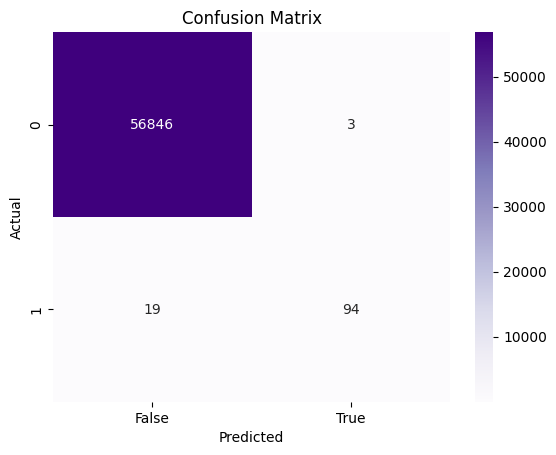

In [11]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test.values.T, y_pred.values.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix')
plt.savefig('ressources/plots/confusion_matrix_ml.png')